In [1]:
__author__ = 'Benjamin Alan Weaver <baweaver@lbl.gov>'
__version__ = '20190515'
__datasets__ = ['sdss_dr14']
__keywords__ = ['extragalactic', 'spectroscopic redshift']

# How to use SDSS Data in NOAO Data Lab

*Benjamin Alan Weaver & NOAO Data Lab Team*

### Table of Contents

* [Goals & Notebook Summary](#Goals)
* [Disclaimer & Attribution](#Disclaimer-&-Attribution)
* [Imports & Setup](#Imports-&-Setup)
* [BOSS Galaxies (photometry)](#BOSS-Galaxies-in-the-SDSS-Photometric-Catalog)
* [BOSS Galaxies (spectroscopy)](#BOSS-Galaxies-in-the-SDSS-Spectroscopic-Catalog)
* [Plotting SDSS Spectra](#Plotting-SDSS-Spectra)
* [Display SDSS Images](#Display-SDSS-Images)
* [Resources & References](#Resources-&-References)

## Goals

Work with SDSS tables in the Data Lab database.

## Notebook Summary

We're bringing the SDSS-III/IV (DR8-DR14) data archive to NOAO, and some of the data are already available in Data Lab.  This notebook demonstrates some queries and plots of SDSS data.

The SDSS website is [www.sdss.org](https://www.sdss.org).

The examples below are primarily focused on target selection and spectroscopy for the [BOSS survey](https://www.sdss.org/surveys/boss/).  This notebook makes extensive use of the target selection algorithms described by [Reid et al. (2016)](http://adsabs.harvard.edu/abs/2016MNRAS.455.1553R).

## Disclaimer & Attribution

If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick *et al.*, "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445
* Data Lab disclaimer: http://datalab.noao.edu/disclaimers.php

## Imports & Setup

### Imports

In [2]:
#
# Standard library imports
#
from contextlib import contextmanager
from getpass import getpass
from io import BytesIO
from bz2 import BZ2File
from time import sleep
#
# Import and configure matplotlib, etc.
#
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.visualization import astropy_mpl_style
import numpy as np
from astropy.io import fits
from astropy.io.votable import parse_single_table
from IPython.core.display import display, HTML
#
# Import Data Lab componets.
#
from dl import queryClient as qc, storeClient as sc

### Matplotlib Configuration

This is separate because some imports may interfere with these settings.

In [3]:
plt.style.use(astropy_mpl_style)
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams['axes.grid'] = True

### SDSS-specific global variables

Set the data release and the corresponding database schema.

In [4]:
release = 14  # DR14
schema = 'sdss_dr{0:d}'.format(release)

### Functions for working with SDSS data

This will help compute some quantities not included in the database.

In [5]:
def auxilliary_colors(data):
    """Compute some artificial color quantities useful for target selection.

    Parameters
    ----------
    data : :class:`numpy.ndarray`
        Array containing MODEL magnitudes.

    Returns
    -------
    :class:`numpy.ndarray`
        Array containing auxilliary colors.
    """
    dt = data['modelmag_r'].dtype
    aux = np.zeros(data.shape, dtype=[(str('c_par'), dt), (str('c_perp'), dt), (str('d_perp'), dt)])
    aux['c_par'] = (0.7 * (data['modelmag_g'] - data['modelmag_r']) +
                    1.2 * (data['modelmag_r'] - data['modelmag_i'] - 0.18))
    aux['c_perp'] = ((data['modelmag_r'] - data['modelmag_i']) - 
                     (data['modelmag_g'] - data['modelmag_r'])/4.0 - 0.18)
    aux['d_perp'] = ((data['modelmag_r'] - data['modelmag_i']) -
                     (data['modelmag_g'] - data['modelmag_r'])/8.0)
    return aux

## BOSS Galaxies in the SDSS Photometric Catalog

Currently, NOAO Data Lab has loaded a subset of the full SDSS photometric catalog containing objects that have spectra in DR14.  All columns that would normally be found in the [PhotoObjAll table](http://skyserver.sdss.org/dr15/en/help/browser/browser.aspx#&&history=description+PhotoObjAll+U) are loaded.

There are several types of flux measurements reported by SDSS.  See the [SDSS Magnitudes page](http://www.sdss.org/dr14/algorithms/magnitudes/) for further details.
We're going to select several measurements of flux, and choose objects marked as `SURVEY_PRIMARY` in the [RESOLVE_STATUS bitmask](http://www.sdss.org/dr14/algorithms/bitmasks/#RESOLVE_STATUS) (see the [resolve](http://www.sdss.org/dr14/algorithms/resolve/) documentation for further details.

Below we construct a query designed to retrieve the values need to re-create targeting cuts.

Note that bitwise operations that are normally part of the SQL standard are forbidden by [ADQL](http://www.ivoa.net/documents/latest/ADQL.html) (even though the `&` operator is part of the ADQL standard).

In [6]:
#
# Create a list of magnitudes to select. This is a lot easier than typing each one.
#
select_magnitudes = ', \n'.join([', '.join(['{0}mag_{1}'.format(magtype, b)
                                          for b in 'ugriz'])
                               for magtype in ('model', 'cmodel', 'psf', 'fiber2')])
#
# Put the query together.
#
q = ("SELECT rerun, run, camcol, field, objid, ra, dec, devrad_i, \n" +
     select_magnitudes + "\n" +
     "FROM {0}.photoplate WHERE (resolvestatus & 256) != 0 LIMIT 100000".format(schema))
print(q)

SELECT rerun, run, camcol, field, objid, ra, dec, devrad_i, 
modelmag_u, modelmag_g, modelmag_r, modelmag_i, modelmag_z, 
cmodelmag_u, cmodelmag_g, cmodelmag_r, cmodelmag_i, cmodelmag_z, 
psfmag_u, psfmag_g, psfmag_r, psfmag_i, psfmag_z, 
fiber2mag_u, fiber2mag_g, fiber2mag_r, fiber2mag_i, fiber2mag_z
FROM sdss_dr14.photoplate WHERE (resolvestatus & 256) != 0 LIMIT 100000


Now submit the query.

In [7]:
%%time
try:
    vot = qc.query(sql=q, fmt='votable', async_=False, timeout=300)
except Exception as e:
    print(e.message)
else:
    result = parse_single_table(BytesIO(vot.encode('utf-8'))).array
    rdev_i = result['devrad_i']/0.396  # convert back to pixels
    auxcolor = auxilliary_colors(result)

CPU times: user 9.66 s, sys: 716 ms, total: 10.4 s
Wall time: 2min 45s


Compute the cuts.

In [8]:
LOWZ = ((result['cmodelmag_r'] < (13.5 + auxcolor['c_par']/0.3)) & 
        (np.abs(auxcolor['c_perp']) < 0.2) &
        (result['cmodelmag_r'] > 16.0) & (result['cmodelmag_r'] < 19.6) &
        ((result['psfmag_r'] - result['cmodelmag_r']) > 0.3))
#
#
#
CMASS = ((result['cmodelmag_i'] < (19.86 + 1.6*(auxcolor['d_perp'] - 0.8))) &
         (result['cmodelmag_i'] > 17.5) & (result['cmodelmag_i'] < 19.9) &
         (auxcolor['d_perp'] > 0.55) &
         ((result['psfmag_i'] - result['modelmag_i']) > (0.2 + 0.2*(20.0 - result['modelmag_i']))) &
         ((result['psfmag_z'] - result['modelmag_z']) > (9.125 - 0.46*result['modelmag_z'])) &
         ((result['modelmag_r'] - result['modelmag_i']) < 2) &
         (result['fiber2mag_i'] < 21.5) & 
         (rdev_i < 20))

How many did we get?  These numbers will vary because the `LIMIT 100000` clause in the query effectively returns a random subsample.

In [9]:
print(LOWZ.sum())
print(CMASS.sum())

13248
18685


Plot color *versus* magnitude.  You can adjust the plot limits where noted below.

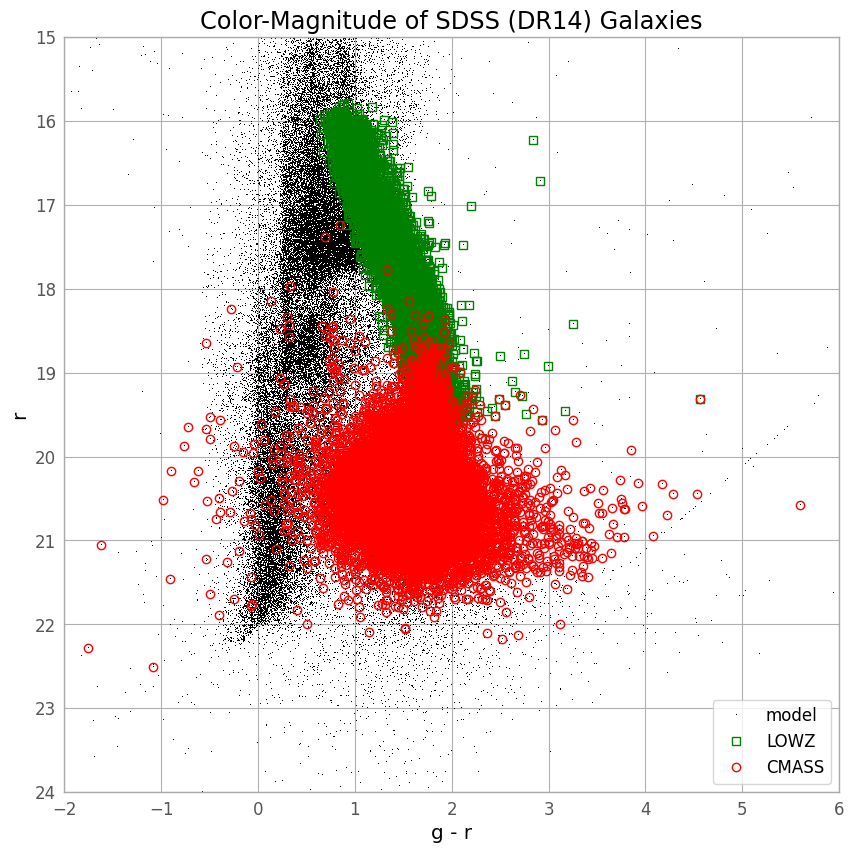

In [10]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
p1 = ax.plot(result['modelmag_g'] - result['modelmag_r'],
             result['modelmag_r'],
             label='model', linestyle='none',
             marker=',', markeredgecolor='k', markerfacecolor='k')
p2 = ax.plot(result['modelmag_g'][LOWZ] - result['modelmag_r'][LOWZ],
             result['modelmag_r'][LOWZ],
             label='LOWZ', linestyle='none',
             marker='s', markeredgecolor='g', markerfacecolor='none')
p3 = ax.plot(result['modelmag_g'][CMASS] - result['modelmag_r'][CMASS],
             result['modelmag_r'][CMASS],
             label='CMASS', linestyle='none',
             marker='o', markeredgecolor='r', markerfacecolor='none')
foo = ax.set_xlim([-2, 6])  # Adjust x axis here. 
foo = ax.set_ylim([24, 15])  # Adjust y axis here.
foo = ax.set_xlabel('g - r')
foo = ax.set_ylabel('r')
foo = ax.set_title('Color-Magnitude of SDSS (DR{0:d}) Galaxies'.format(release))
l = ax.legend(numpoints=1)

Plot a color-color diagram.  The default plot limits should give a square plot.

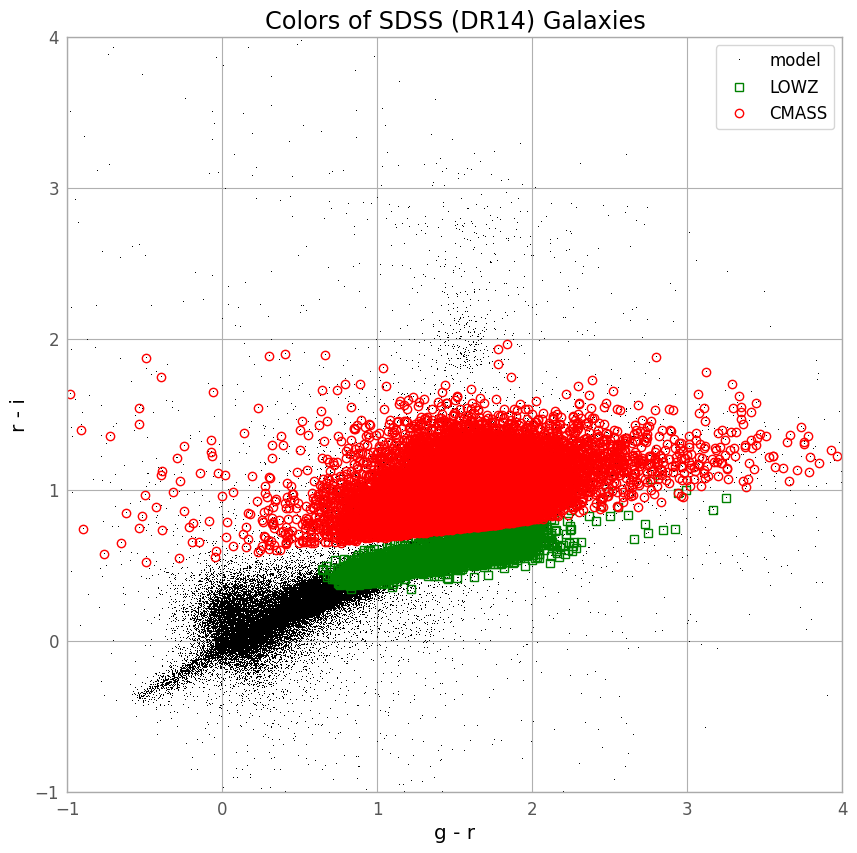

In [11]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
p1 = ax.plot(result['modelmag_g'] - result['modelmag_r'],
             result['modelmag_r'] - result['modelmag_i'],
             label='model', linestyle='none',
             marker=',', markeredgecolor='k', markerfacecolor='k')
p2 = ax.plot(result['modelmag_g'][LOWZ] - result['modelmag_r'][LOWZ], 
             result['modelmag_r'][LOWZ] - result['modelmag_i'][LOWZ],
             label='LOWZ', linestyle='none',
             marker='s', markeredgecolor='g', markerfacecolor='none')
p3 = ax.plot(result['modelmag_g'][CMASS] - result['modelmag_r'][CMASS], 
             result['modelmag_r'][CMASS] - result['modelmag_i'][CMASS],
             label='CMASS', linestyle='none',
             marker='o', markeredgecolor='r', markerfacecolor='none')
foo = ax.set_xlim([-1, 4])  # Adjust x axis here. 
foo = ax.set_ylim([-1, 4])  # Adjust y axis here. 
foo = ax.set_xlabel('g - r')
foo = ax.set_ylabel('r - i')
foo = ax.set_title('Colors of SDSS (DR{0:d}) Galaxies'.format(release))
l = ax.legend(numpoints=1)

## BOSS Galaxies in the SDSS Spectroscopic Catalog

### Number of Objects

How many objects are in the specObj table?

In [12]:
%%time
q = "SELECT COUNT(*) AS nrows FROM {0}.specobj".format(schema)
result = qc.query(adql=q, fmt='csv')
print(result)

nrows
4311571

CPU times: user 29.6 ms, sys: 0 ns, total: 29.6 ms
Wall time: 4.66 s


### Select LOWZ and CMASS spectra.

The [BOSS_TARGET1 bitmask](http://www.sdss.org/dr13/algorithms/bitmasks/#BOSS_TARGET1) makes this very easy.  SDSS [uses bitmasks extensively](http://www.sdss.org/dr13/algorithms/bitmasks/)!

In [13]:
%%time
q = ("SELECT boss_target1 FROM {0}.specobj WHERE boss_target1 != 0 LIMIT 100000".format(schema))
try:
    vot = qc.query(sql=q, fmt='votable')
except Exception as e:
    print(e.message)
else:
    result = parse_single_table(BytesIO(vot.encode('utf-8'))).array
    boss_target1 = result['boss_target1']
    print(boss_target1)

[1048576 1048576 140 ... 2199023779840 134 135]
CPU times: user 565 ms, sys: 56.5 ms, total: 621 ms
Wall time: 12.2 s


How many of each type of target did we get?  The link to `BOSS_TARGET1` above gives the meaning of each value.  In many cases the individuals are bitwise-AND-ed together, since an object in the sky could be targeted for several reasons.

In [14]:
for mask in (1, 5, 6, 9, 14, 15, 33, 41, 133, 134, 135, 140, 141, 142):
    print(mask, (boss_target1 == mask).sum())

1 18391
5 0
6 0
9 0
14 0
15 0
33 0
41 0
133 1
134 53030
135 545
140 3880
141 0
142 0


Select LOWZ galaxies and print how many we found.

In [15]:
%%time
q_lowz = ("SELECT specobjid, fluxobjid, bestobjid, plate, mjd, fiberid, z_noqso FROM {0}.specobj " + 
          "WHERE (boss_target1 & {1:d}) != 0 AND scienceprimary = 1 AND " +
          "zwarning_noqso = 0 AND class_noqso = 'GALAXY' LIMIT 100000").format(schema, 1)
try:
    vot = qc.query(sql=q_lowz, fmt='votable')
except Exception as e:
    print(e.message)
else:
    result = parse_single_table(BytesIO(vot.encode('utf-8'))).array
    plate_lowz = result['plate']
    mjd_lowz = result['mjd']
    fiber_lowz = result['fiberid']
    redshift_lowz = result['z_noqso']
    print(len(redshift_lowz))

100000
CPU times: user 2.34 s, sys: 181 ms, total: 2.52 s
Wall time: 34.7 s


Select CMASS galaxies and print how many we found.

In [16]:
%%time
q_cmass = ("SELECT specobjid, fluxobjid, bestobjid, plate, mjd, fiberid, z_noqso FROM {0}.specobj " + 
           "WHERE (boss_target1 & {1:d}) != 0 AND scienceprimary = 1 AND " +
           "zwarning_noqso = 0 AND class_noqso = 'GALAXY' LIMIT 100000").format(schema, 2)
try:
    vot = qc.query(sql=q_cmass, fmt='votable')
except Exception as e:
    print(e.message)
else:
    result = parse_single_table(BytesIO(vot.encode('utf-8'))).array
    plate_cmass = result['plate']
    mjd_cmass = result['mjd']
    fiber_cmass = result['fiberid']
    redshift_cmass = result['z_noqso']
    print(len(redshift_cmass))

100000
CPU times: user 2.37 s, sys: 125 ms, total: 2.5 s
Wall time: 33.9 s


### Redshift Distribution

Here's the redshift distribution of LOWZ and CMASS galaxies.  Note that the number of bins for CMASS is chosen so the bin *sizes* are approximately the same as the LOWZ sample (when the entire data set can be queried).

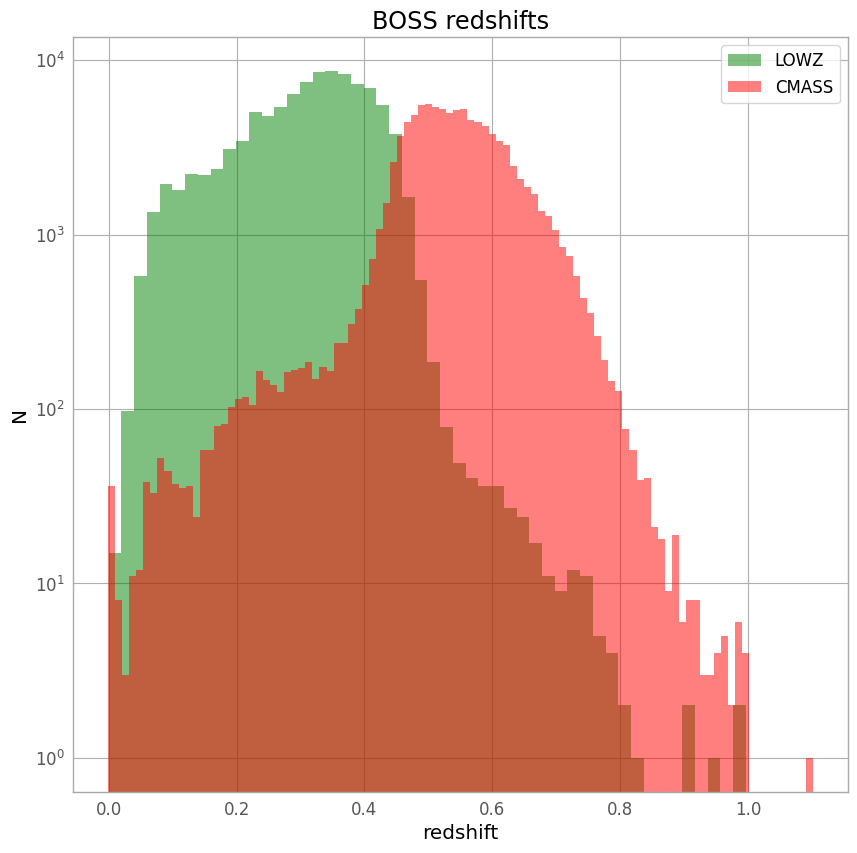

In [17]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
n_lowz, bins_lowz, patches_lowz = ax.hist(redshift_lowz, 50, facecolor='green', alpha=0.5, label='LOWZ')
n_cmass, bins_cmass, patches_cmass = ax.hist(redshift_cmass, 100, facecolor='red', alpha=0.5, label='CMASS')
foo = ax.set_yscale('log')
foo = ax.set_xlabel("redshift")
foo = ax.set_ylabel("N")
foo = ax.set_title("BOSS redshifts")
foo = ax.legend()

### What's that? Some CMASS Galaxies have negative redshift?

Let's actually take a look at these spectra.  The "SkyServer" link will show a simple spectrum along with an image of the targeted object.  The "SAS" link will show an interactive view of the spectrum with options to download the spectrum itself.

In [18]:
rerun = 'v5_10_0'
negative_z = (redshift_cmass >= bins_cmass[0]) & (redshift_cmass < bins_cmass[1])
display(HTML('<ul>'))
for p, m, f in zip(plate_cmass[negative_z], mjd_cmass[negative_z], fiber_cmass[negative_z]):
    display(HTML(('<li>' +
                  '<a href="https://skyserver.sdss.org/dr{0:d}/en/tools/explore/summary.aspx?plate={2}&mjd={3}&fiber={4}">SkyServer: {2}, {3}, {4}</a></li>'.format(release, rerun, p, m, f) +
                  '<a href="https://dr{0:d}.sdss.org/optical/spectrum/view?run2d={1}&plateid={2}&mjd={3}&fiberid={4}">SAS: {2}, {3}, {4}</a>'.format(release, rerun, p, m, f) +
                  '</li>')))
display(HTML('</ul>'))

After looking at a few of these, you may notice (from the "SkyServer" link) that a number of them are point-like, red objects that are close to a brighter object.  A plausible hypothesis is that CMASS color selection doesn't work so great when a nearby, brighter object might be contaminating the photometry, thus making it harder to distinguish LRGs from M stars.

## Plotting SDSS Spectra

In addition to databases that contain the SDSS catalog data, NOAO Data Lab will also contain the images and spectra themselves.  In fact, some spectroscopic data is already in the NOAO archive, so we can plot it directly from a Data Lab notebook!

First, we need some helper functions.

In [19]:
def extract_spectrum(plate, mjd, fiber, run2d='v5_10_0', release=14, sas='sdss_dr14://'):
    """Extract a spectrum from a spPlate file.
    
    Parameters
    ----------
    plate : :class:`int`
        Plate of observation.
    mjd : :class:`int`
        MJD of observation.
    fiber : :class:`int`
        Fiber number.
    run2d : :class:`str`, optional
        Reduction id.
    release : :class:`int`, optional
        Data release number.
    sas : :class:`str`, optional
        Root path to SDSS data.
    
    Returns
    -------
    :func:`tuple`
        A tuple containing wavelength, flux, inverse variance of flux, and sky spectrum.
    """
    vopath = "{0}sdss/spectro/redux/{1}/{2:04d}/spPlate-{2:04d}-{3:05d}.fits".format(sas, run2d, plate, mjd)
    with fits.open(sc.get(vopath, mode='fileobj')) as hdulist:
        hdr = hdulist[0].header
        flux = hdulist[0].data[fiber-1, :]
        ivar = hdulist[1].data[fiber-1, :]
        sky = hdulist[6].data[fiber-1, :]
    loglam = hdr['COEFF0'] + hdr['COEFF1']*np.arange(hdr['NAXIS1'], dtype=flux.dtype)
    wavelength = 10.0**loglam
    return wavelength, flux, ivar, sky


def plot_spectrum(plate, mjd, fiber, showsky=False, **kwargs):
    """Simple SDSS/BOSS spectrum plot.
    
    Parameters
    ----------
    plate : :class:`int`
        Plate of observation.
    mjd : :class:`int`
        MJD of observation.
    fiber : :class:`int`
        Fiber number.
    showsky : :class:`bool`, optional
        If ``True``, plot the sky spectrum
    """
    wavelength, flux, ivar, sky = extract_spectrum(plate, mjd, fiber, **kwargs)
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(111)
    p0 = ax.plot(wavelength, flux, 'k-', linewidth=1, label='OBJECT')
    if showsky:
        p1 = ax.plot(wavelength, sky, 'm-', linewidth=1, label='SKY')
    foo = ax.set_title("{0:04d}-{1:05d}-{2:04d}".format(plate, mjd, fiber))
    foo = ax.set_xlabel("Wavelength [Å]")
    foo = ax.set_ylabel(r"Flux [$10^{-17} \; \mathrm{erg} \; \mathrm{cm}^{-2} \; \mathrm{s}^{-1} \; \mathrm{\AA}^{-1}$]")
    l = ax.legend()

First, some spectra that, like the previous list, were targeted as distant galaxies but have very low redshift.  You can get a better view of these spectra from the links above, but this demonstrates the fun fact that many BOSS spectra are *fainter* than the sky!

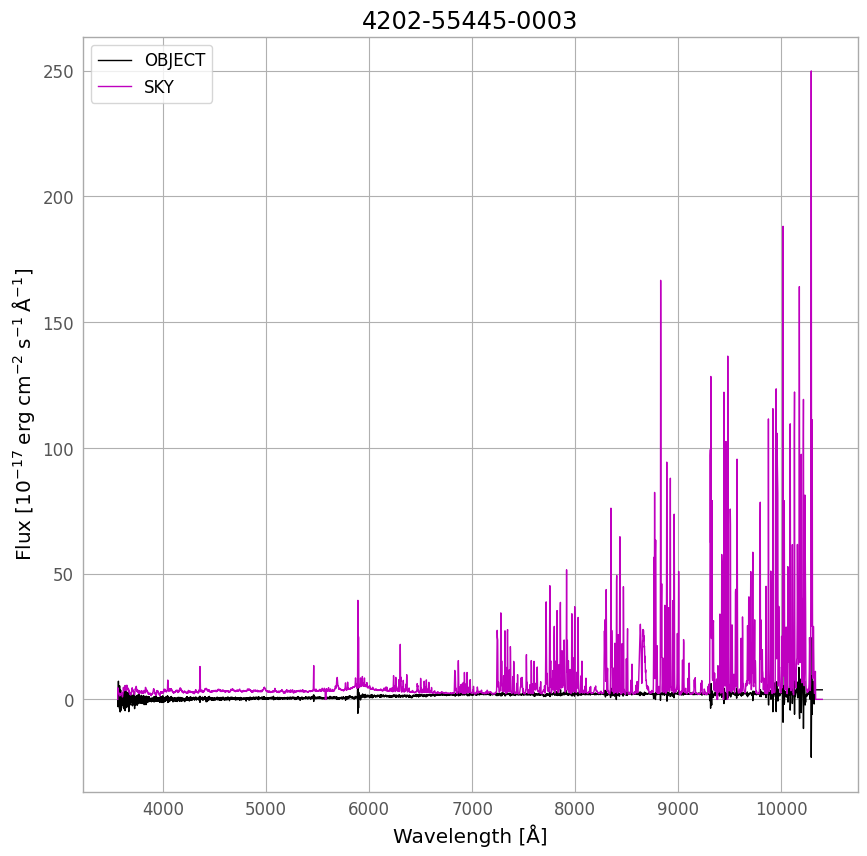

In [20]:
plot_spectrum(4202, 55445, 3, showsky=True)

Here's another of the same type.  If you look in the 6000 - 8000 Å range, you can see some features that resemble certain M stars.

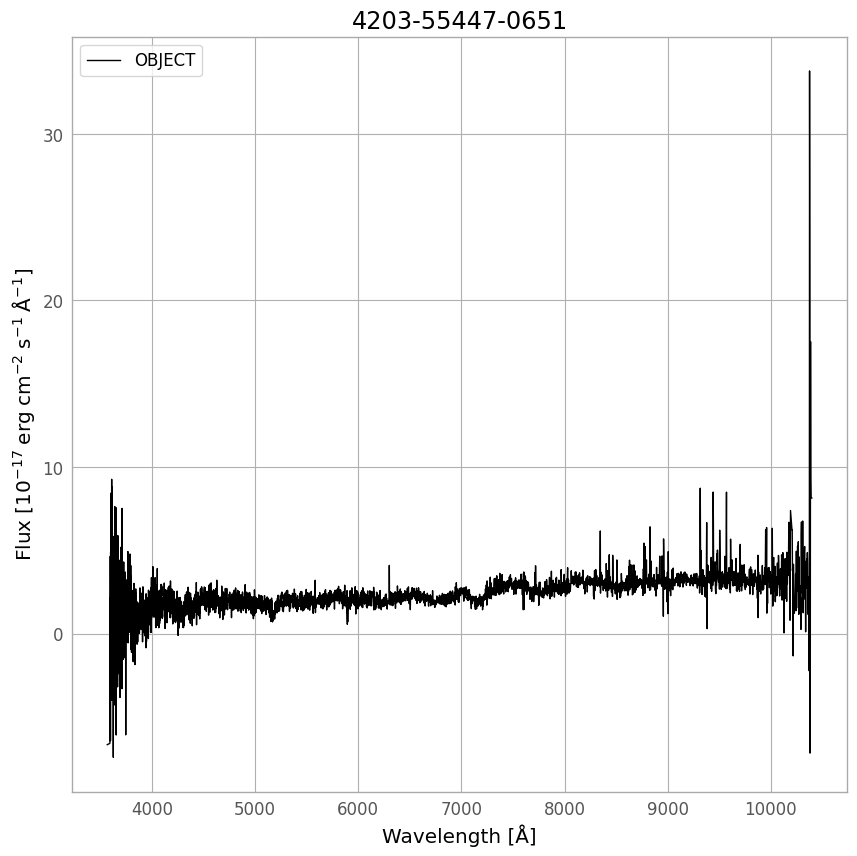

In [21]:
plot_spectrum(4203, 55447, 651)

Here's a "classic" LRG at redshift 0.67 (which was actually targeted as LOWZ!).

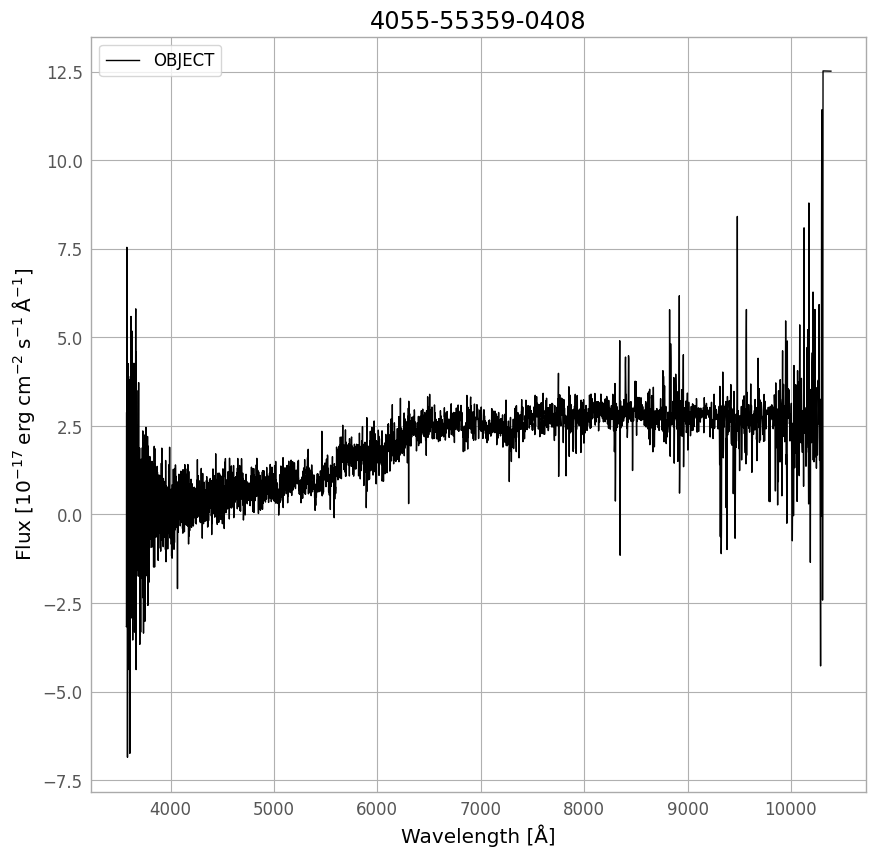

In [22]:
plot_spectrum(4055, 55359, 408)

## Display SDSS Images

Here we will gain some practice plotting corrected frame images in Data Lab.  The original image is [here](https://dr12.sdss.org/fields/runCamcolField?field=13&camcol=1&run=6122).  "Corrected frames" are images that have been both sky-subtracted and calibrated such that individual pixels have physical flux units.  In the case of SDSS images the units are [nanomaggies](https://www.sdss.org/dr15/help/glossary/#nanomaggie).  The SDSS corrected frames are described [here](https://data.sdss.org/datamodel/files/BOSS_PHOTOOBJ/frames/RERUN/RUN/CAMCOL/frame.html).

First, some utility functions for extracting the images.

In [23]:
def asinh_image(image, band='r'):
    """Convert an image in nanomaggies into asinh magnitudes.
    
    Parameters
    ----------
    image : :class:`numpy.ndarray`
        Image data, read from *e.g.* a SDSS-III corrected frame file.
    band : :class:`str`, optional
        Filter band, default *r*.
    
    Returns
    -------
    :class:`numpy.ndarray`
        Image data converted to asinh magnitudes.
    """
    C = -2.5/np.log(10.0)
    b = dict(u=1.4e-10, g=0.9e-10, r=1.2e-10, i=1.8e-10, z=7.4e-10)
    mag = C*(np.arcsinh((image*1.0e-9)/(2.0*b[band])) + np.log(b[band]))
    return mag


#
# Reading the files is an expensive operation, so cache the results.
#
extract_frame_cache = dict()


def extract_frame(run, camcol, field, band, sas='sdss_dr14://'):
    """Obtain image data from a SDSS corrected frame, which may be at a remote location.

    Parameters
    ----------
    run : :class:`int`
        Run number.
    camcol : :class:`int`
        Column number.
    field : :class:`int`
        Field number
    band : :class:`str`
        Filter band.
    sas : :class:`str`, optional
        Root path to SDSS data.
    
    Returns
    -------
    :class:`numpy.ndarray`
        Image data.
    """
    fm = '{0}eboss/photoObj/frames/301/{1:d}/{2:d}/frame-{3}-{1:06d}-{2:d}-{4:04d}.fits.bz2'.format(sas, run, camcol, band, field)
    if fm not in extract_frame_cache:
        with BZ2File(BytesIO(sc.get(fm, mode='binary'))) as cf:
            with fits.open(cf) as hdulist:
                extract_frame_cache[fm] = hdulist[0].data
    return extract_frame_cache[fm]


def display_frame(run, camcol, field, band, asinh=False, invert=False, **kwargs):
    """Display a SDSS corrected frame.
    
    Parameters
    ----------
    run : :class:`int`
        Run number.
    camcol : :class:`int`
        Column number.
    field : :class:`int`
        Field number.
    band : :class:`str`
        Filter band.
    asinh : :class:`bool`, optional
        If ``True``, pixel values will be converted to asinh magnitudes.
    invert : :class:`bool`, optional
        If ``True`` display an inverted grayscale image.
    sas : :class:`str`, optional
        Root path to SDSS data.

    Returns
    -------
    :func:`tuple`
         Handles to the figure, image and colorbar.
    """
    color_map = 'gray_r'
    if invert:
        color_map = 'gray'
    image = extract_frame(run, camcol, field, band, **kwargs)
    clim=(0.0, 1.0)
    if asinh:
        image = asinh_image(image, band=band)
        clim=(26, 18)
    fig = plt.figure(dpi=100)
    im = plt.imshow(image, cmap=color_map, clim=clim, origin='lower')
    foo = im.axes.set_title('frame-{0}-{1:06d}-{2:d}-{3:04d}.fits'.format(band, run, camcol, field))
    cb = plt.colorbar()
    return fig, im, cb

Start with *r* band, with no special display options, except we invert the grayscale so the sky is dark.

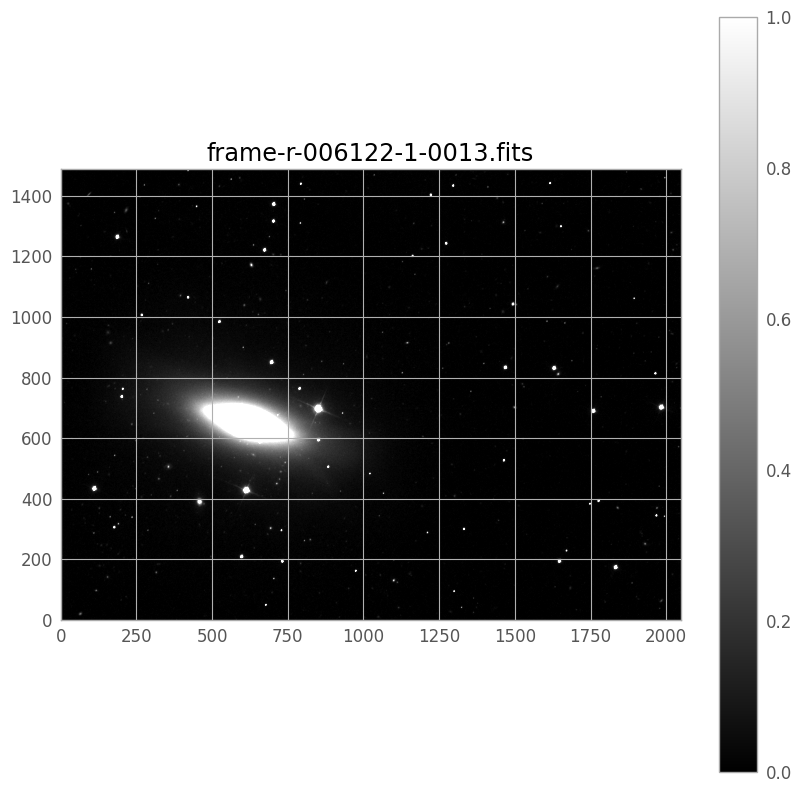

In [24]:
fig, im, cb = display_frame(6122, 1, 13, 'r', invert=True)

Display a histogram of the pixels.  We demonstrate the histogram to justify the grayscale limits in the function above.  In this case, the vast majority of pixels are in the range `[0, 1]`.

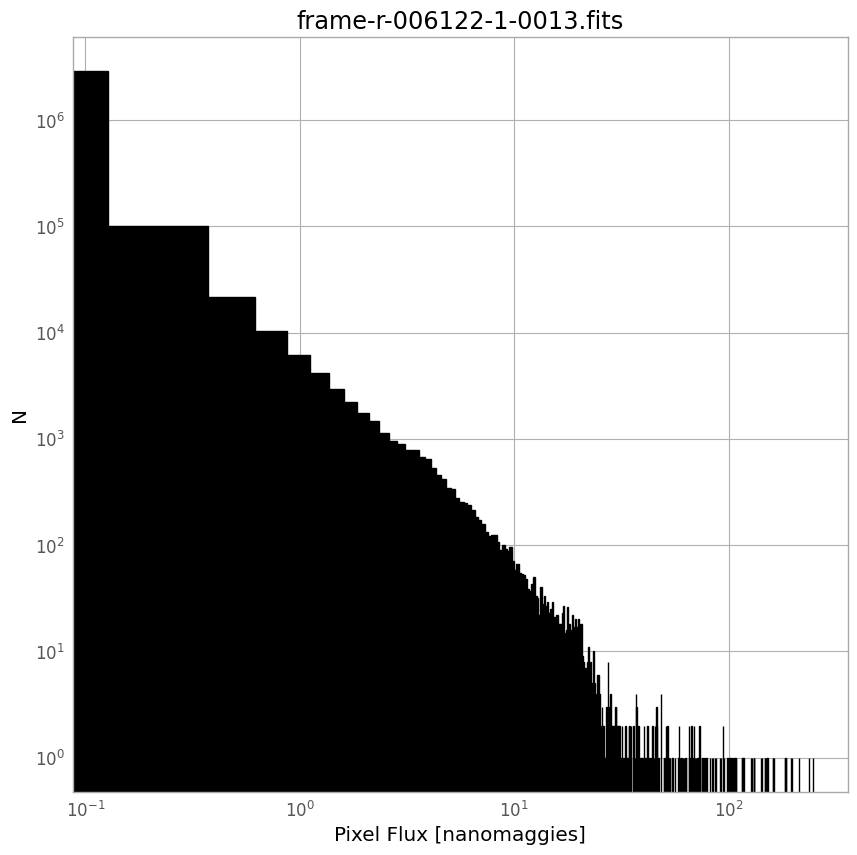

In [25]:
image = im.get_array().data
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(image.flatten(), bins=1000, facecolor='k', edgecolor='k')
foo = ax.set_xscale('log')
foo = ax.set_yscale('log')
foo = ax.set_xlabel('Pixel Flux [nanomaggies]')
foo = ax.set_ylabel('N')
foo = ax.set_title('frame-r-006122-1-0013.fits')

Now, display an image with the pixels converted to magnitude units.  We don't need to invert this image because larger magnitude is darker.

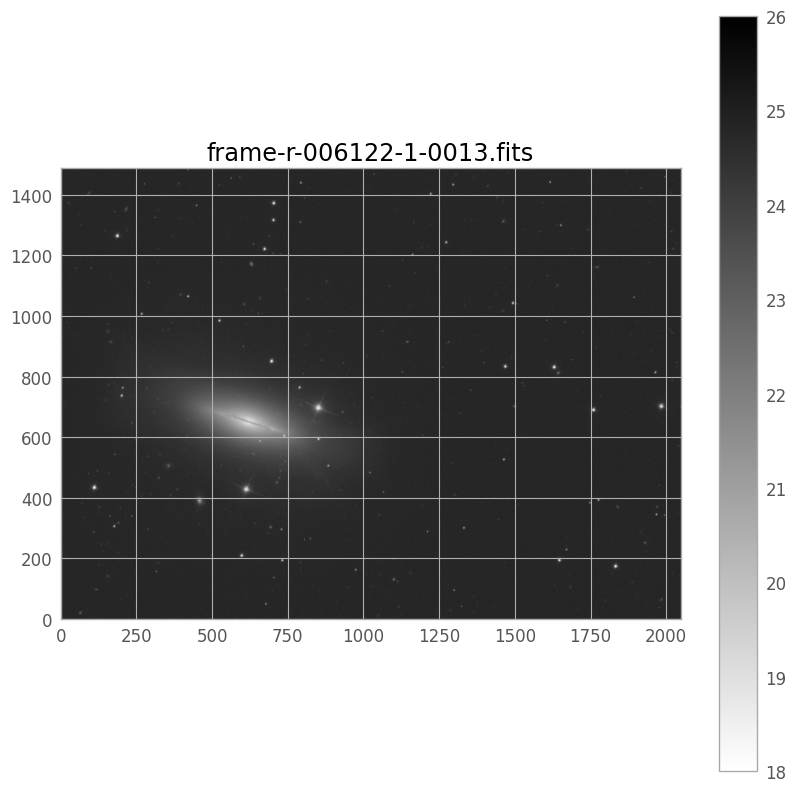

In [26]:
fig, im, cb = display_frame(6122, 1, 13, 'r', asinh=True)

Similarly histogram the pixels.

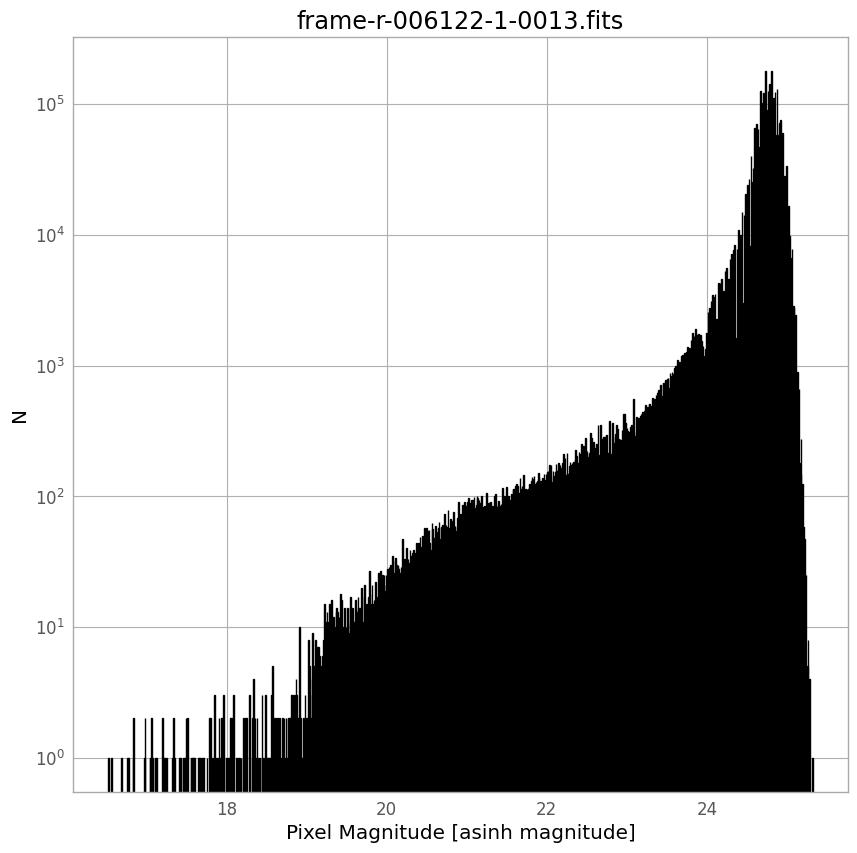

In [27]:
mag_image = im.get_array().data
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(mag_image.flatten(), bins=1000, facecolor='k', edgecolor='k')
# foo = ax.set_xscale('log')
foo = ax.set_yscale('log')
foo = ax.set_xlabel('Pixel Magnitude [asinh magnitude]')
foo = ax.set_ylabel('N')
foo = ax.set_title('frame-r-006122-1-0013.fits')

Invert the magnitude image.

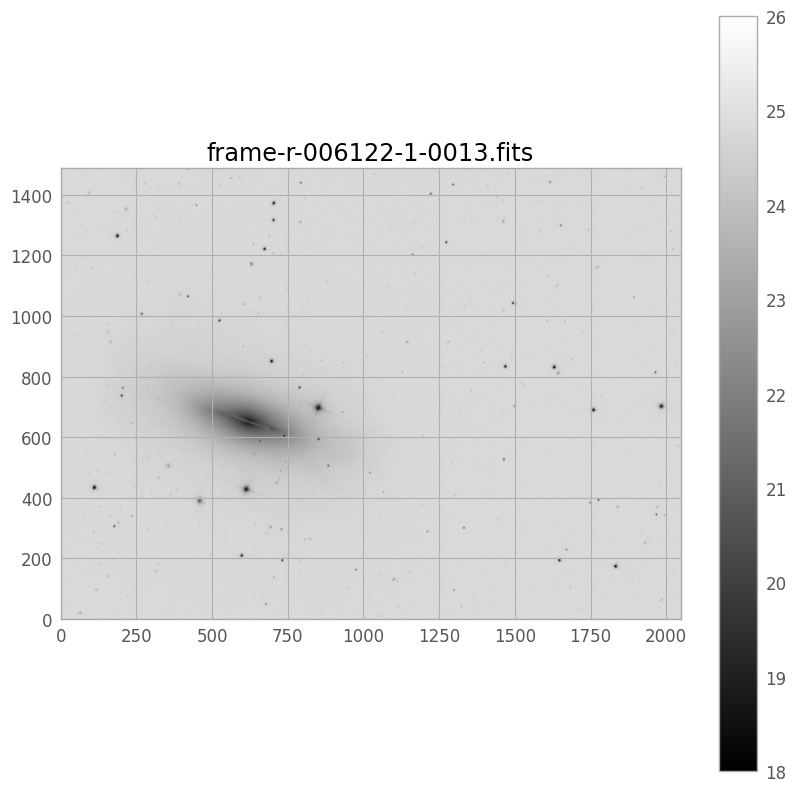

In [28]:
fig, im, cb = display_frame(6122, 1, 13, 'r', asinh=True, invert=True)

And take a look at the other colors.

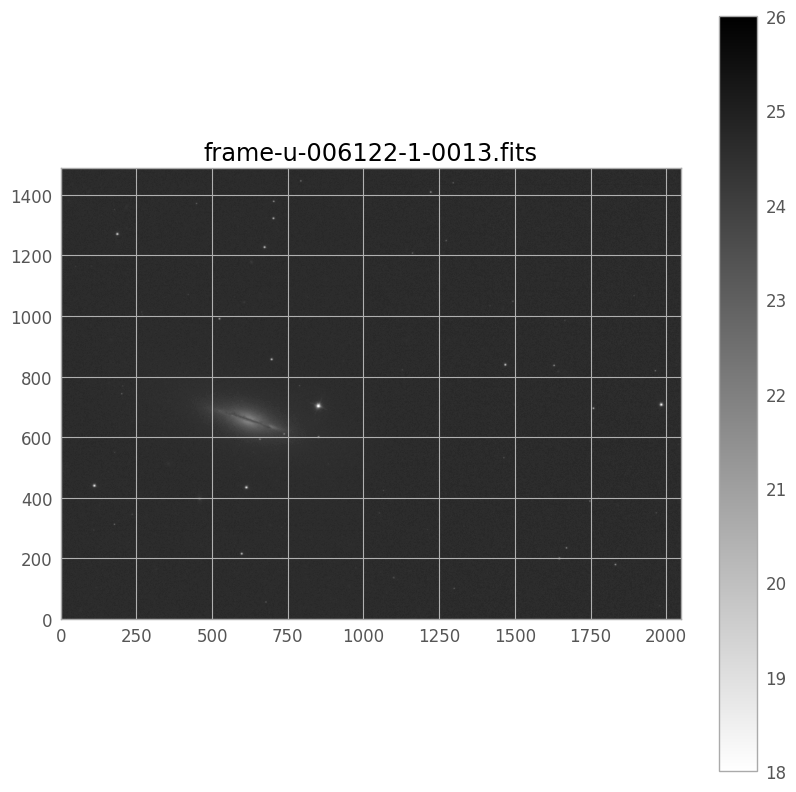

In [29]:
foo = display_frame(6122, 1, 13, 'u', asinh=True)

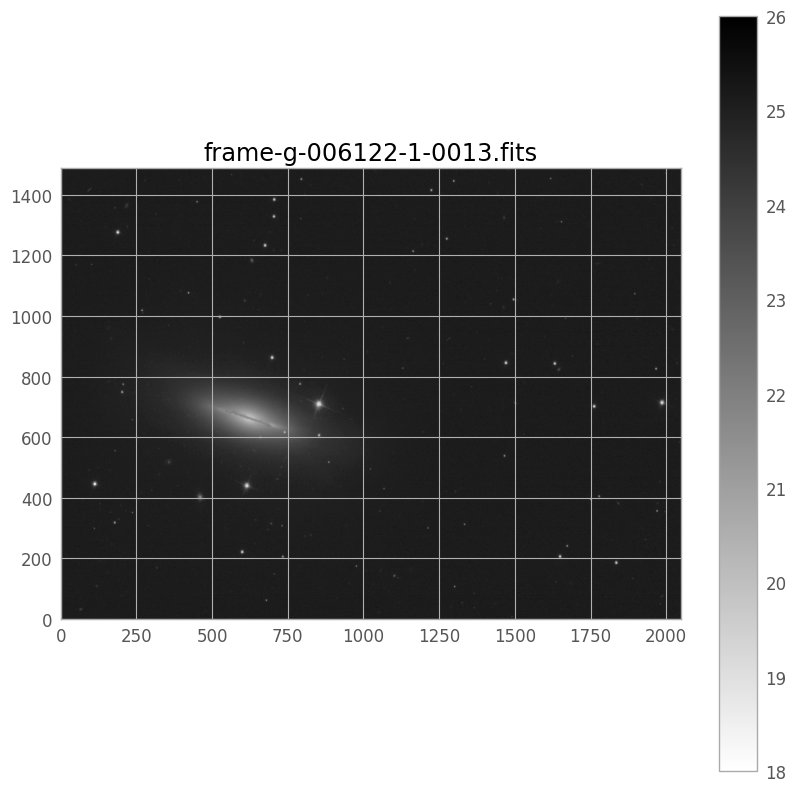

In [30]:
foo = display_frame(6122, 1, 13, 'g', asinh=True)

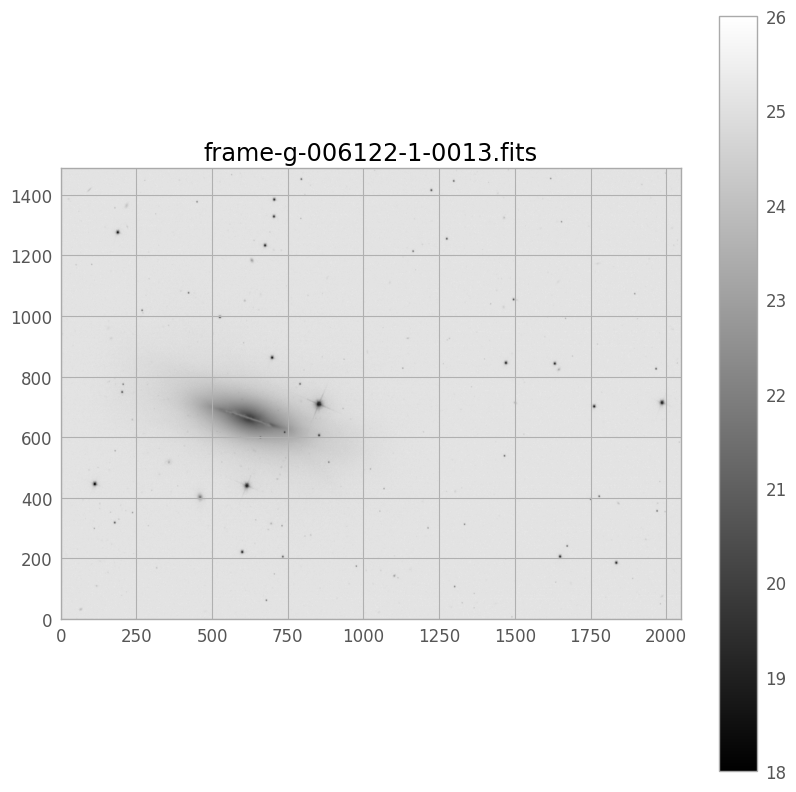

In [31]:
foo = display_frame(6122, 1, 13, 'g', asinh=True, invert=True)

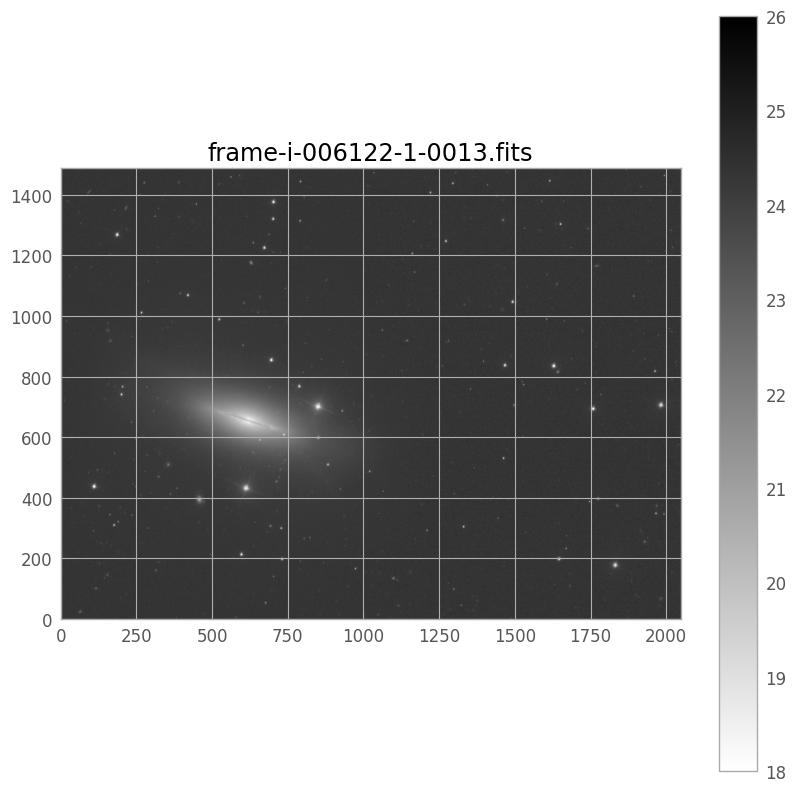

In [32]:
foo = display_frame(6122, 1, 13, 'i', asinh=True)

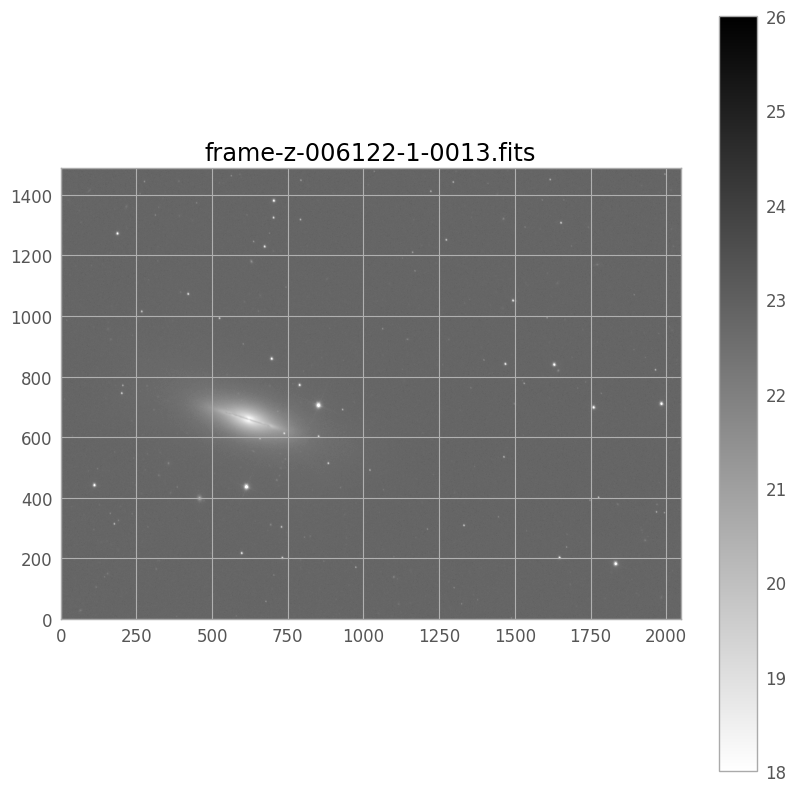

In [33]:
foo = display_frame(6122, 1, 13, 'z', asinh=True)

## Resources & References

* BOSS: [Kyle S. Dawson, *et al.*, "The Baryon Oscillation Spectroscopic Survey of SDSS-III," *Astron. J.* **145** (2013) 10.](http://adsabs.harvard.edu/abs/2013AJ....145...10D)
* eBOSS: [Kyle S. Dawson, *et al.*, "The SDSS-IV extended Baryon Oscillation Spectroscopic Survey: Overview and Early Data," *Astron. J.* **151** (2016) 44.](http://adsabs.harvard.edu/abs/2016AJ....151...44D)
* SDSS-IV: [Michael R. Blanton, *et al.*, "Sloan Digital Sky Survey IV: Mapping the Milky Way, Nearby Galaxies and the Distant Universe," *Astron. J.* **154** (2017) 28.](http://adsabs.harvard.edu/abs/2017AJ....154...28B)
* DR13: [Franco D. Albareti, *et al.*, "The 13th Data Release of the Sloan Digital Sky Survey: First Spectroscopic Data from the SDSS-IV Survey Mapping Nearby Galaxies at Apache Point Observatory," *Astrophys. J. Supp.* **233** (2017) 25.](http://adsabs.harvard.edu/abs/2017ApJS..233...25A)
* DR14: [Bela Abolfathi, *et al.*, "The Fourteenth Data Release of the Sloan Digital Sky Survey: First Spectroscopic Data from the extended Baryon Oscillation Spectroscopic Survey and from the Second Phase of the Apache Point Observatory Galactic Evolution Experiment," *Astrophys. J. Supp.* **235** (2018) 42.](http://adsabs.harvard.edu/abs/2018ApJS..235...42A)